# Classical dataset

In this notebook we will train VAIR on the abstract dataset presented in Section 3.2 of our manuscript. We will concentrate here in the absence of an external magnetic field, and aim to reproduce the panel b) in Figure 3 of the manuscript.

## Dataset generation
We start by generating the dataset, which consists on stacks of trajectories from two different actions, the mass and electric actions.

In [1]:
from air.datasets.classical_exp import hammer_electric_dataset_double_traj as classical_dataset
import numpy as np

# Dataset parameters
dataset_size = int(1e4) 
size_train = 0.8
BS = 50
device = 'cuda'

# We consider trajectories of 200 points
times = np.linspace(0.,2,200)

import torch
torch.manual_seed(1)
data, loader_test, loader = classical_dataset(dataset_size = dataset_size,
                                              size_train= size_train,
                                              BS = BS,
                                              times = times,
                                              device = device, key_jax=0)

As we can see below, one input consists on an observation, which in this case contains the concatenation of two 2D trajectories, hence a total size of $200\times 2\times 2 = 800$, and the representation of the action, which in this case is a one-hot vector of length 2. 

In [2]:
batch = next(iter(loader_test))[0]
batch.shape, batch[0,-2:]

(torch.Size([50, 802]), tensor([1., 0.], device='cuda:0'))

## VAIR training
We now define the VAIR architecture and train it on the classical dataset. We consider a latent space of dimension $d_z=2$ as used in the manuscript. This is a simplification made to facilitate the visualization and understanding of VAIR properties. Similar results can be achieved with larger latent spaces. 

In [3]:
from air.models import VAIR

# Training hyperparameters
dim_actions = 2
dim_z = 2
lr, beta = (1e-4, 0.001)
epochs = 200


# We set a seed for reproducibility
torch.manual_seed(12)

# VAIR model
AE = VAIR(dim_x = 2*times.shape[0]*2, # Dimension input to encoder
              dim_z = dim_z, # Dimension latent
              dim_a = dim_actions, # Dimension action representation               
              dim_y = times.shape[0]*2,
       ).to(device)

We use the fastai library to train the model. As loss, we consider the usual $\beta$-VAE loss with reconstruction objective given by the mean squared error (MSE). We also use a custom callbacks to save the values of the log-variances of the latent variables over epochs.

In [4]:
from fastai.vision.all import Learner, Adam
from air.losses_metrics import beta_mse_loss, save_logvars, save_separate_losses

learn = Learner(data, 
              AE,
              loss_func = beta_mse_loss(loss_objective = 'H',
                                          beta = beta,
                                          recon_objective='mse'), 
              opt_func= Adam,
              cbs = (
                     save_logvars(),
                     save_separate_losses(loader)
                     )     
              )

with learn.no_logging(): learn.fit(epochs, lr = lr)

## Analysis

### Variances over epochs
We start by showing the evolution of the log-variances over epochs for each action (see manuscript for details). In particular, we see that both neurons are passive, being active only for one action each:

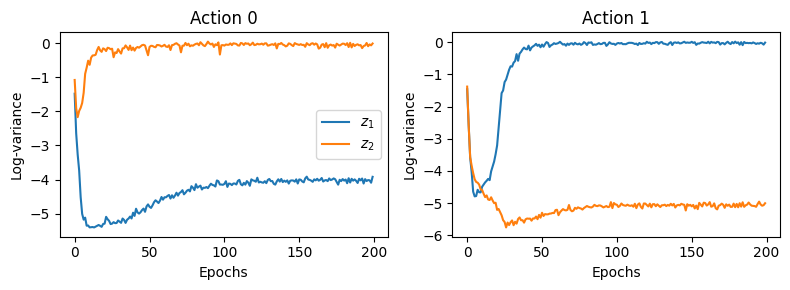

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize = (8, 3), tight_layout = True)
for idx in range(2):
    ax[idx].plot(learn.save_logvars.logvars[:,idx].detach().cpu(), label = [r'$z_1$',r'$z_2$']);
    ax[idx].set_title(f'Action {idx}');
ax[0].legend()
plt.setp(ax, xlabel = 'Epochs', ylabel = 'Log-variance');

### Observation representation in the latent space
Thanks to its dual encoder, it is very easy to analyze how the observations $x$ are represented in the latent space $z$. We will now generate trajectories for a grid of mass and charge values, and encode them with the trained model to see how they are represented in the latent space. We will then compare these representations with the theoretical expectations presented in the manuscript. First, we define the grid of mass and charge values, and generate the corresponding trajectories:

In [10]:
from air.datasets.classical_exp import create_traj_mass, create_traj_charge

T = times.size
num_trajs = 100
# We define the grid of mass and charge values based on the values used for training
charges = np.linspace(-1.7, -0.5, num_trajs)
masses  = np.linspace(0.4,  1.75,  num_trajs)
charges_grid, masses_grid = np.meshgrid(charges, masses)

# We now generate the trajectories based on the chosen charges and masses grid
trajs_h = create_traj_mass(times = times, masses = np.repeat(masses, num_trajs)).reshape(-1, 2*T)
trajs_e = create_traj_charge(times = times, masses = np.repeat(masses, num_trajs), charges=np.tile(charges, num_trajs)).reshape(-1, 2*T)
# We concatenate the trajectories to make them ready for the encoder E_x
input_trajs = torch.from_numpy(np.concatenate([trajs_h, trajs_e], axis=1)).to(device)

# Now we predict the means of the latent neurons using E_x, and reshape for latter plotting
mus = learn.E_x(input_trajs).detach().cpu().reshape(num_trajs, num_trajs, -1).numpy()

We plot now the mean of each neuron as a function of the mass and charge values:

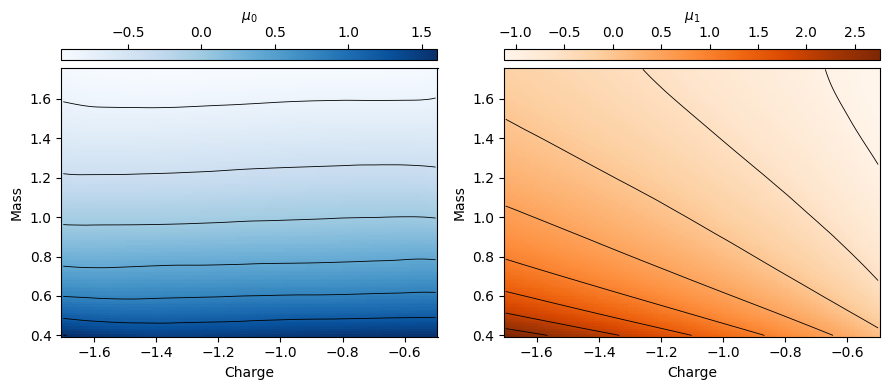

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), tight_layout = True)
from mpl_toolkits.axes_grid1 import make_axes_locatable


for idx_z, ax, mu in zip(range(2), axes, mus.transpose(2, 0, 1)):
    im = ax.pcolormesh(charges_grid, masses_grid, mu, shading="auto", cmap = 'Blues' if idx_z == 0 else 'Oranges')
    ax.contour(
        charges_grid,
        masses_grid,
        mu,
        colors="k",
        linewidths=0.6,
        negative_linestyles="solid",
    )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="4%", pad=0.08)
    cb = ax.figure.colorbar(im, cax=cax, orientation="horizontal", label = fr'$\mu_{idx_z}$')
    cax.xaxis.set_ticks_position("top")
    cax.xaxis.set_label_position("top")

plt.setp(axes, xlabel='Charge', ylabel='Mass');

As can be seen, the first neuron encodes the mass in almost a linear fashion, while the second neuron encodes a ratio between the mass and the charge, which is indeed proportional to the factor $m/q$, as commented in the manuscript.